In [24]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.models import model_from_yaml
from keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
import json
import os

import common
from importlib import reload
%matplotlib inline


In [2]:
reload(common)

(train_sentences, train_categories, test_sentences, test_categories) = common.load_dataset('../dataset/redis_dataset.csv', split=0.8)
print(train_sentences.shape)

9849
(7879,)


In [3]:
#
# Parameters
#
max_features = 6000
maxlen = 160
batch_size = 128
embedding_dims = 100
filters = 100
kernel_size = 3
hidden_dims = 100
epochs = 10


In [4]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

print('Found %s unique tokens.' % len(dictionary))

# Let's save this out so we can use it later
with open('models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)


Found 5398 unique tokens.


In [5]:
#
# Load Glove embeddings
#
glove_dir = '/Users/nscsekhar/Desktop/nscsekhar/Desktop/Surya/Personal/MIDS/W266/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#
# Get Embedding matrix
#
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, i in dictionary.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [6]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# print(train_sequences[:10])

Pad sequences (samples x time)
x_train shape: (7879, 160)
x_test shape: (1970, 160)


In [7]:
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
#                     weights=[embedding_matrix],
#                     trainable=False,
                    input_length=maxlen))
model.add(Dropout(0.1))


In [8]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

In [9]:
model.add(GlobalMaxPooling1D())

In [10]:
model.add(Dense(hidden_dims))
model.add(Dropout(0.1))
model.add(Activation('relu'))

In [11]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 100)          600000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 158, 100)          30100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
__________

In [12]:
reload(common)

tbCallback = TensorBoard(log_dir='./logs/cnn', histogram_freq=0,
                          write_graph=True, write_images=False)

metrics = common.Metrics()

history = model.fit(x_train, train_categories,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, test_categories), 
          callbacks=[metrics, tbCallback])


Train on 7879 samples, validate on 1970 samples
Epoch 1/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.6259 - acc: 0.6508 - val_loss: 0.5574 - val_acc: 0.7442
Epoch 2/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.4509 - acc: 0.7905 - val_loss: 0.4527 - val_acc: 0.7751
Epoch 3/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.3431 - acc: 0.8490 - val_loss: 0.4250 - val_acc: 0.7964
Epoch 4/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.2545 - acc: 0.8985 - val_loss: 0.4528 - val_acc: 0.7924
Epoch 5/10
7879/7879 [==============================] - 10s 1ms/step - loss: 0.1812 - acc: 0.9299 - val_loss: 0.4870 - val_acc: 0.7949
Epoch 6/10
7879/7879 [==============================] - 9s 1ms/step - loss: 0.1278 - acc: 0.9580 - val_loss: 0.5440 - val_acc: 0.7914
Epoch 7/10
7879/7879 [==============================] - 9s 1ms/step - loss: 0.0815 - acc: 0.9737 - val_loss: 0.6029 - val_acc: 0.7939
Epoch 8/1

In [13]:
reload(common)
metrics.print_all()

Precision: 0.7406296851574213
Recall: 0.8027397260273973
F1: 0.7436548223350254


In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

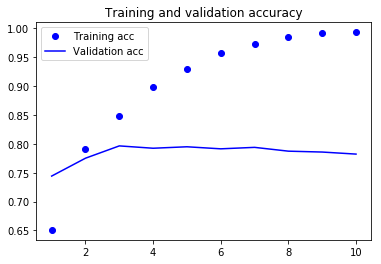

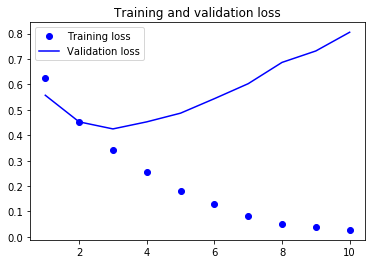

In [15]:
reload(common)
common.plot_model_history(history)

In [19]:
#
# Save the model as a yaml
#
model_yaml = model.to_yaml()
with open("models/cnn_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("models/cnn_model.h5")
print("Saved model to disk")


Saved model to disk


In [20]:
# load YAML and create model
yaml_file = open("models/cnn_model.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("models/cnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, test_categories, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 78.22%


In [21]:
#
# Load a new source file
#
# reload(common)
test_file='/tmp/fe-connect.c'
comment_sents = []

#
# Get comment sentences
#
comment_sents += common.get_comment_sents(test_file)
# print(len(comment_sents))
# for sent in comment_sents:
#     print(sent)


In [22]:
#
# Predict the comment sentences
#
reload(common)
import json

pred_tokenizer = Tokenizer(num_words=max_features)
labels = ['Needs Fix', 'Good comment']
count_zero = count_one = 0

with open('models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

for sent in comment_sents:
    print("Sentence: \n",sent)
    comment_sequence = common.convert_text_to_index_array(sent, dictionary)
    comment_vector = sequence.pad_sequences([comment_sequence], maxlen=maxlen)

    pred = loaded_model.predict_classes(comment_vector)
    print("Readability score: ", labels[int(pred)])
    if pred == 0:
        count_zero += 1
    else:
        count_one += 1
    

Sentence: 
  mstcpip.h is missing on mingw
Readability score:  Good comment
Sentence: 
  OpenLDAP deprecates RFC 1823, but we want standard conformance
Readability score:  Needs Fix
Sentence: 
   Pre-9.0 servers will return this SQLSTATE if asked to set  application_name in a startup packet.
Readability score:  Good comment
Sentence: 
 We hard-wire the value rather  than looking into errcodes.h since it reflects historical behavior  rather than that of the current code.
Readability score:  Good comment
Sentence: 
  This is part of the protocol so just define it
Readability score:  Needs Fix
Sentence: 
  This too
Readability score:  Needs Fix
Sentence: 
   Cope with the various platform-specific ways to spell TCP keepalive socket  options.
Readability score:  Needs Fix
Sentence: 
 This doesn't cover Windows, which as usual does its own thing.
Readability score:  Needs Fix
Sentence: 
  TCP_KEEPIDLE is the name of this option on Linux and BSD
Readability score:  Good comment
Sentence: 
  

Readability score:  Needs Fix
Sentence: 
   Insert remaining parameters into struct, overriding defaults (as well  as any conflicting data from dbName taken as a conninfo).
Readability score:  Needs Fix
Sentence: 
   Compute derived options
Readability score:  Needs Fix
Sentence: 
   Connect to the database
Readability score:  Needs Fix
Sentence: 
  ----------  connectNoDelay -  Sets the TCP_NODELAY socket option.
Readability score:  Good comment
Sentence: 
 Returns 1 if successful, 0 if not.
Readability score:  Needs Fix
Sentence: 
  ----------  connectFailureMessage -  create a friendly error message on connection failure.
Readability score:  Good comment
Sentence: 
  HAVE_UNIX_SOCKETS
Readability score:  Needs Fix
Sentence: 
   Optionally display the network address with the hostname.
Readability score:  Good comment
Sentence: 
 This is  useful to distinguish between IPv4 and IPv6 connections.
Readability score:  Needs Fix
Sentence: 
  To which host and port were we actually connect

Readability score:  Needs Fix
Sentence: 
   Now we expect to hear from the backend.
Readability score:  Good comment
Sentence: 
 A ReadyForQuery  message indicates that startup is successful, but we might  also get an Error message indicating failure.
Readability score:  Good comment
Sentence: 
 (Notice  messages indicating nonfatal warnings are also allowed by  the protocol, as are ParameterStatus and BackendKeyData  messages.)
Readability score:  Needs Fix
Sentence: 
 Easiest way to handle this is to let  PQgetResult() read the messages.
Readability score:  Needs Fix
Sentence: 
 We just have to fake it  out about the state of the connection, by setting  asyncStatus = PGASYNC_BUSY (done above).
Readability score:  Needs Fix
Sentence: 
   NULL return indicating we have gone to IDLE state is  expected
Readability score:  Needs Fix
Sentence: 
   If we tried to send application_name, check to see  if the error is about that --- pre-9.0 servers will  reject it at this stage of the process.

Readability score:  Needs Fix
Sentence: 
   Try PGSERVICEFILE if specified, else try ~ or .pg_service.conf (if that  exists).
Readability score:  Good comment
Sentence: 
   This could be used by any application so we can't use the binary  location to find our config files.
Readability score:  Good comment
Sentence: 
  ignore EOL at end of line
Readability score:  Needs Fix
Sentence: 
  ignore leading blanks
Readability score:  Needs Fix
Sentence: 
  ignore comments and empty lines
Readability score:  Needs Fix
Sentence: 
  Check for right groupname
Readability score:  Needs Fix
Sentence: 
  group info already read
Readability score:  Needs Fix
Sentence: 
   Finally, we are in the right group and can parse the line
Readability score:  Good comment
Sentence: 
  if rc = 2, go on reading for fallback
Readability score:  Good comment
Sentence: 
   Set the parameter --- but don't override any previous  explicit setting.
Readability score:  Good comment
Sentence: 
  PQconninfoParse   Parse a 

Readability score:  Needs Fix
Sentence: 
  Get a password from the password file.
Readability score:  Good comment
Sentence: 
 Return value is malloc'd.
Readability score:  Needs Fix
Sentence: 
  'localhost' matches pghost of '' or the default socket directory
Readability score:  Needs Fix
Sentence: 
   We should probably use canonicalize_path(), but then we have to  bring path.c into libpq, and it doesn't seem worth it.
Readability score:  Needs Fix
Sentence: 
  If password file cannot be opened, ignore it.
Readability score:  Good comment
Sentence: 
  If password file is insecure, alert the user and ignore it.
Readability score:  Needs Fix
Sentence: 
   On Win32, the directory is protected, so we don't have to check the  file.
Readability score:  Needs Fix
Sentence: 
  Remove trailing newline
Readability score:  Good comment
Sentence: 
  Handle DOS-style line endings, too, even when not on Windows
Readability score:  Needs Fix
Sentence: 
  Found a match.
Readability score:  Needs Fix

In [23]:
print("Comments Needing Fix:", count_zero)
print("Good Comments:", count_one)

Comments Needing Fix: 546
Good Comments: 240
